In [1]:
!pip install split-folders


In [2]:
import numpy as np
import pickle
import cv2
import splitfolders
import tensorflow as tf 
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils.image_utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from re import sub



In [3]:
import os
os.listdir("/kaggle/input/plantvillage-dataset")

['segmented', 'grayscale', 'plantvillage dataset', 'color']

In [4]:
# Set some default variables
DATA_DIR = '/kaggle/input/plantvillage-dataset/color'
BATCH_SIZE = 32
EPOCHS = 6
IMAGE_SHAPE = (224, 224)

In [5]:
# Check the content

pairs = list()
number = list()

for directory in os.listdir(path=DATA_DIR):
    columns = directory.split('___')
    columns.append(directory)
    
    sub_path = DATA_DIR + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))
    
    pairs.append(columns)
    
pairs = pd.DataFrame(pairs, columns=['Plant', 'Disease', 'Directory', 'Files'])
pairs.sort_values(by='Plant')

,Plant,Disease,Directory,Files
27,Apple,healthy,Apple___healthy,1645
20,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,275
16,Apple,Black_rot,Apple___Black_rot,621
13,Apple,Apple_scab,Apple___Apple_scab,630
17,Blueberry,healthy,Blueberry___healthy,1502
18,Cherry_(including_sour),Powdery_mildew,Cherry_(including_sour)___Powdery_mildew,1052
30,Cherry_(including_sour),healthy,Cherry_(including_sour)___healthy,854
31,Corn_(maize),Common_rust_,Corn_(maize)___Common_rust_,1192
10,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
37,Corn_(maize),healthy,Corn_(maize)___healthy,1162


In [6]:
# Make a directory images
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))

In [7]:
# Split the data into folders
DATA_DIR = '/kaggle/input/plantvillage-dataset/color'
splitfolders.ratio(DATA_DIR,output = "images",seed = 42,ratio = (0.80,0.10,0.10))

Copying files: 54305 files [06:53, 131.17 files/s]


In [8]:
# Set the directories Paths we saved before

TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"
PATHS = [TRAIN_PATH, VAL_PATH, TEST_PATH]

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)


In [10]:
train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 43429 images belonging to 38 classes.


In [11]:
val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 5417 images belonging to 38 classes.


In [12]:
test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                          class_mode="categorical",
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          color_mode='rgb',
                                          shuffle = False)

Found 5459 images belonging to 38 classes.


In [13]:
BATCH_SIZE = 32
IMG_SIZE = (255, 255)
train_dataset = image_dataset_from_directory(DATA_DIR,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)


Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [14]:
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Black_rot
3.  Apple___Cedar_apple_rust
4.  Apple___healthy
5.  Blueberry___healthy
6.  Cherry_(including_sour)___Powdery_mildew
7.  Cherry_(including_sour)___healthy
8.  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9.  Corn_(maize)___Common_rust_
10.  Corn_(maize)___Northern_Leaf_Blight
11.  Corn_(maize)___healthy
12.  Grape___Black_rot
13.  Grape___Esca_(Black_Measles)
14.  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15.  Grape___healthy
16.  Orange___Haunglongbing_(Citrus_greening)
17.  Peach___Bacterial_spot
18.  Peach___healthy
19.  Pepper,_bell___Bacterial_spot
20.  Pepper,_bell___healthy
21.  Potato___Early_blight
22.  Potato___Late_blight
23.  Potato___healthy
24.  Raspberry___healthy
25.  Soybean___healthy
26.  Squash___Powdery_mildew
27.  Strawberry___Leaf_scorch
28.  Strawberry___healthy
29.  Tomato___Bacterial_spot
30.  Tomato___Early_blight
31.  Tomato___Late_blight
32.  Tomato___Leaf_Mold
33.  Tomato___Septoria_leaf_spot
34.  Tomato_

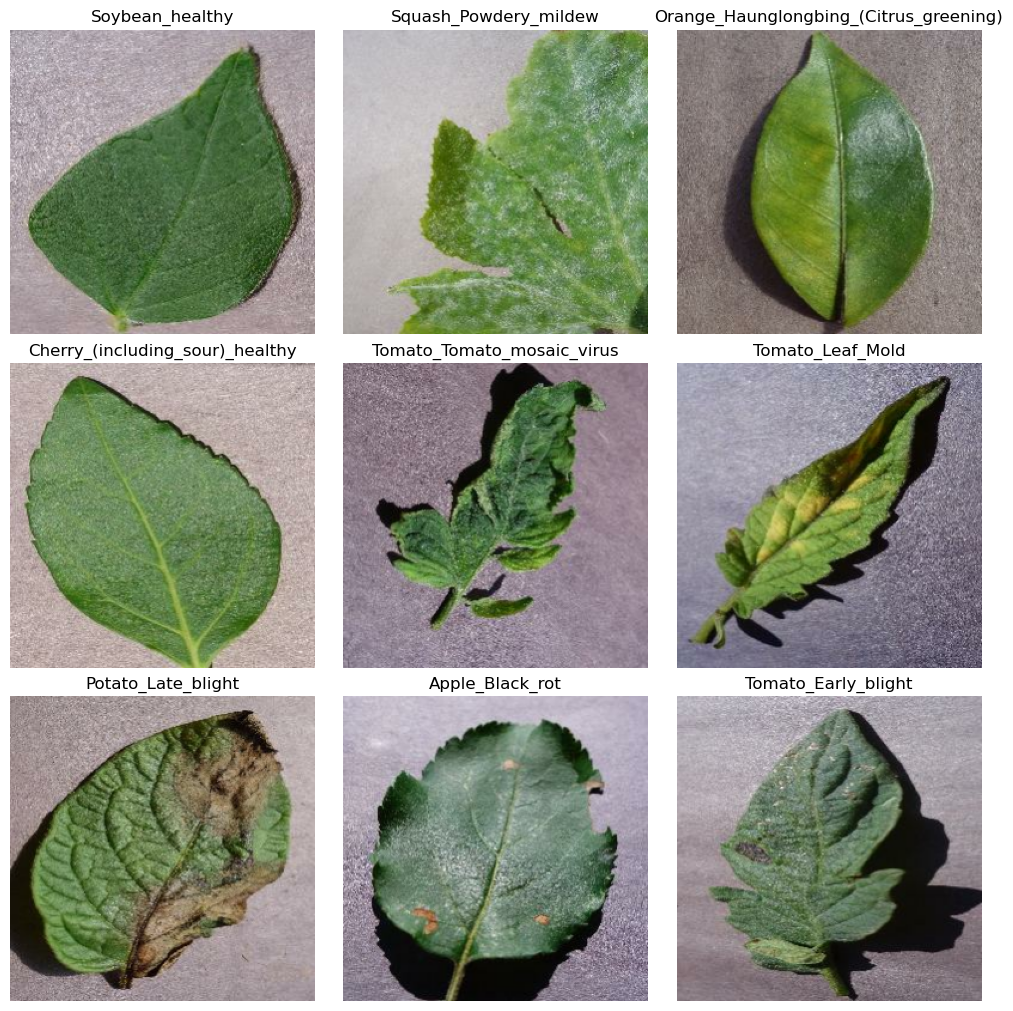

In [15]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Create model object
model = Sequential()

# Set input shape
inputShape = (224, 224, 3)



# Add layers to the model
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(38, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print summary of the model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     896       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        1

In [17]:
pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 37.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


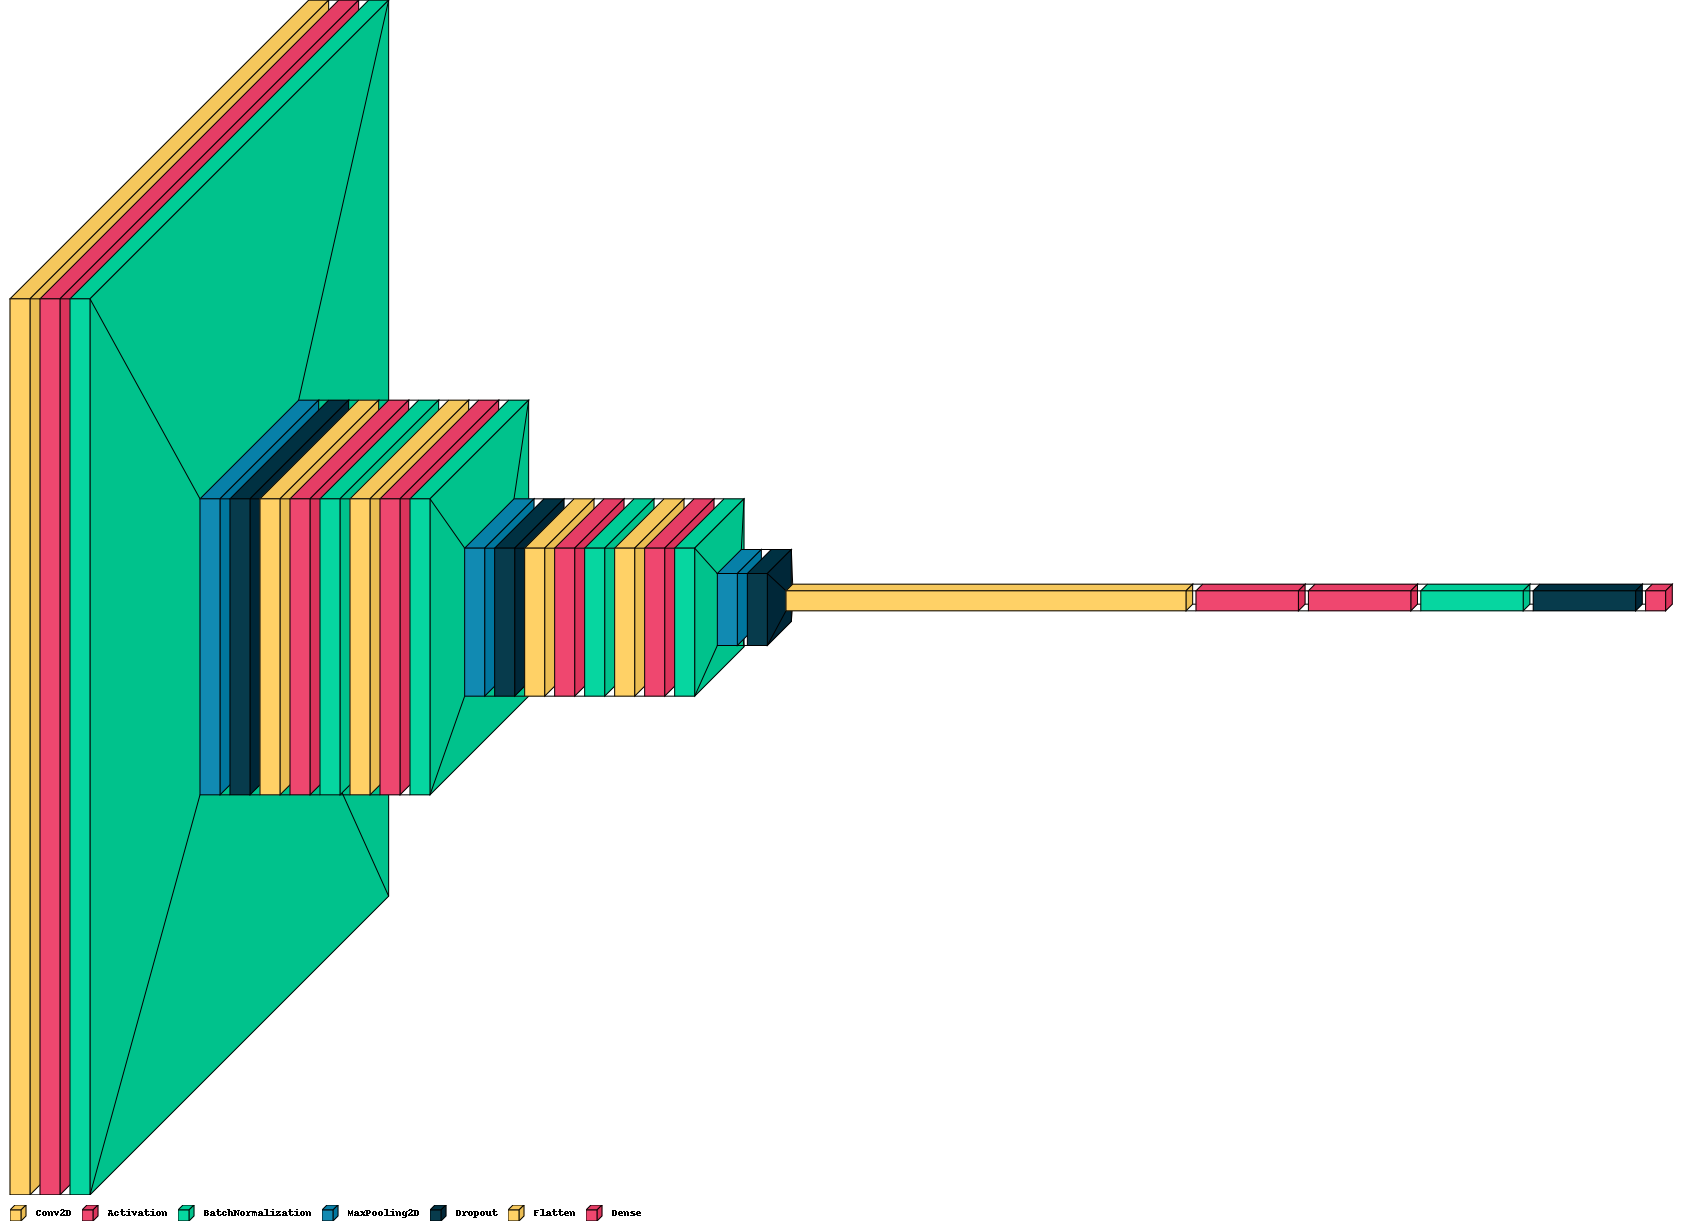

In [18]:
import visualkeras

from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def train_cnn_with_early_stopping(model, train_gen, val_gen, epochs, patience):
    # define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

    # train the model with early stopping
    history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[early_stopping])

    # return the trained model and the training history
    return model, history

In [21]:
model, history = train_cnn_with_early_stopping(model, train_gen, val_gen, epochs=17, patience=10)


Epoch 1/17


2023-05-10 14:15:28.761559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1358/1358 [==============================] - 133s 91ms/step - loss: 1.9966 - accuracy: 0.4596 - val_loss: 1.4755 - val_accuracy: 0.5499
Epoch 2/17
1358/1358 [==============================] - 122s 90ms/step - loss: 1.3033 - accuracy: 0.6084 - val_loss: 2.0732 - val_accuracy: 0.4979
Epoch 3/17
1358/1358 [==============================] - 133s 98ms/step - loss: 1.0502 - accuracy: 0.6796 - val_loss: 0.6724 - val_accuracy: 0.7870
Epoch 4/17
1358/1358 [==============================] - 128s 94ms/step - loss: 0.8076 - accuracy: 0.7504 - val_loss: 1.4185 - val_accuracy: 0.6088
Epoch 5/17
1358/1358 [==============================] - 129s 95ms/step - loss: 0.6937 - accuracy: 0.7867 - val_loss: 0.5397 - val_accuracy: 0.8453
Epoch 6/17
1358/1358 [==============================] - 121s 89ms/step - loss: 0.5089 - accuracy: 0.8394 - val_loss: 2.1212 - val_accuracy: 0.5522
Epoch 7/17
1358/1358 [==============================] - 126s 93ms/step - loss: 0.5260 - accuracy: 0.8338 - val_loss: 0.4179 - val

In [22]:
pd.DataFrame(history.history)


,loss,accuracy,val_loss,val_accuracy
0,1.996569,0.459578,1.475507,0.549935
1,1.303306,0.608441,2.073225,0.497877
2,1.050219,0.679592,0.672358,0.786967
3,0.807613,0.750397,1.418504,0.608824
4,0.693733,0.786686,0.539738,0.845302
5,0.508868,0.839439,2.121237,0.552151
6,0.526017,0.833775,0.417900,0.887761
7,0.530685,0.835548,0.499864,0.841241
8,0.436417,0.860393,2.545455,0.716264
9,0.410207,0.868982,0.451910,0.913421


In [23]:
import matplotlib.pyplot as plt

def Res_Plot_Test_Save(name, model, history):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

    #print("[INFO] Saving model")
    #model.save(name)
    plt.savefig(name)

[INFO] Plotting model accuracy and Loss


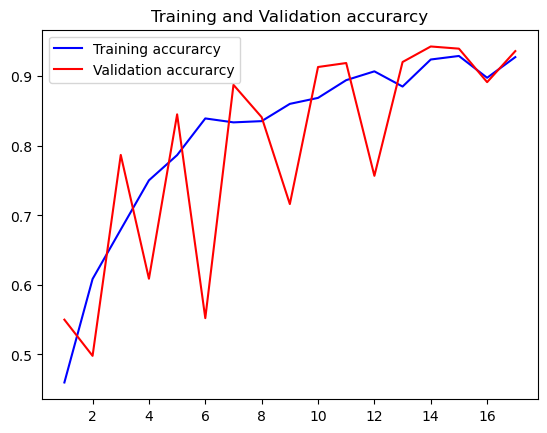

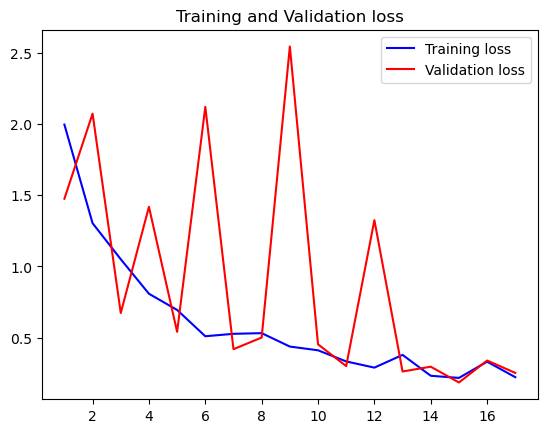

<Figure size 640x480 with 0 Axes>

In [24]:
Res_Plot_Test_Save('CNN_model.png', model, history)

In [25]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(val_gen)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
170/170 [==============================] - 12s 71ms/step - loss: 0.2513 - accuracy: 0.9363
Test Accuracy: 93.63116025924683


In [26]:
from tensorflow.keras.applications.vgg19 import VGG19

# Load the pre-trained VGG19 model
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set all layers to not trainable
for layer in vgg.layers:
    layer.trainable = False

# Add layers to the model
VGG19_model = Sequential()
VGG19_model.add(vgg)
VGG19_model.add(Flatten())
VGG19_model.add(Dense(1024))
VGG19_model.add(Activation("relu"))
VGG19_model.add(BatchNormalization())
VGG19_model.add(Dropout(0.5))
VGG19_model.add(Dense(38, activation='softmax'))

# Compile the model
VGG19_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


80134624/80134624 [==============================] - 4s 0us/step


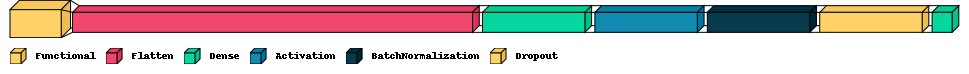

In [27]:
import visualkeras

from PIL import ImageFont
visualkeras.layered_view(VGG19_model, legend=True)

In [28]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


In [29]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def train_VGG19_with_early_stopping(model, train_gen, val_gen, epochs, patience):
    # define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

    # train the model with early stopping
    # Fit the model
    history_vgg = VGG19_model.fit(train_generator,steps_per_epoch=train_generator.samples // 32,epochs=20,validation_data=val_generator,validation_steps=val_generator.samples // 32,callbacks=[early_stopping])

    # return the trained model and the training history
    return VGG19_model, history_vgg

In [30]:
VGG19_model, history_vgg = train_cnn_with_early_stopping(VGG19_model, train_gen, val_gen, epochs=20, patience=5)


Epoch 1/20
1358/1358 [==============================] - 151s 108ms/step - loss: 0.4322 - accuracy: 0.8681 - val_loss: 0.2598 - val_accuracy: 0.9151
Epoch 2/20
1358/1358 [==============================] - 139s 102ms/step - loss: 0.1910 - accuracy: 0.9384 - val_loss: 0.1910 - val_accuracy: 0.9372
Epoch 3/20
1358/1358 [==============================] - 162s 119ms/step - loss: 0.1446 - accuracy: 0.9506 - val_loss: 0.1945 - val_accuracy: 0.9396
Epoch 4/20
1358/1358 [==============================] - 145s 106ms/step - loss: 0.1157 - accuracy: 0.9612 - val_loss: 0.1854 - val_accuracy: 0.9413
Epoch 5/20
1358/1358 [==============================] - 138s 102ms/step - loss: 0.0989 - accuracy: 0.9662 - val_loss: 0.1768 - val_accuracy: 0.9470
Epoch 6/20
1358/1358 [==============================] - 147s 108ms/step - loss: 0.0852 - accuracy: 0.9714 - val_loss: 0.1802 - val_accuracy: 0.9450
Epoch 7/20
1358/1358 [==============================] - 138s 102ms/step - loss: 0.0761 - accuracy: 0.9745 - val_

In [31]:
print("[INFO] Calculating model accuracy")
scores = VGG19_model.evaluate(val_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
170/170 [==============================] - 16s 92ms/step - loss: 0.1556 - accuracy: 0.9614
Test Accuracy: 96.14177346229553


[INFO] Plotting model accuracy and Loss


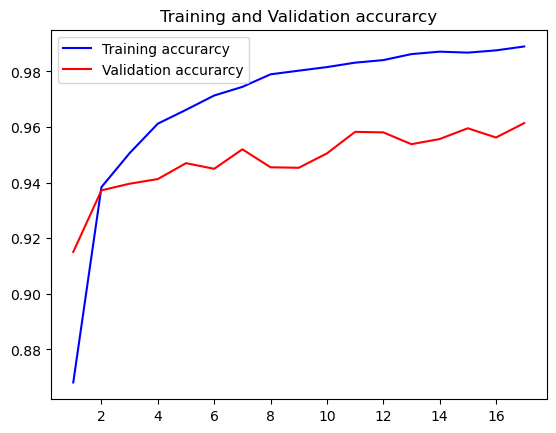

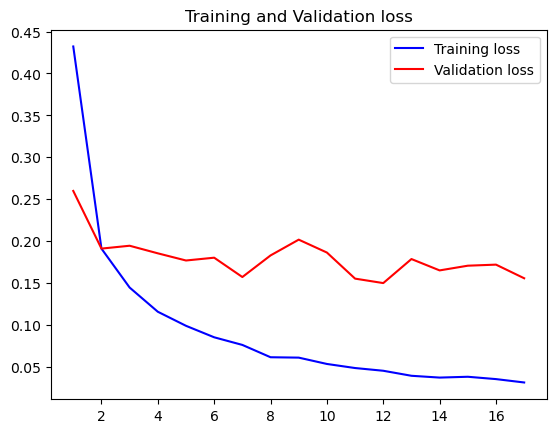

<Figure size 640x480 with 0 Axes>

In [32]:
Res_Plot_Test_Save('VGG_model.png', VGG19_model, history_vgg)